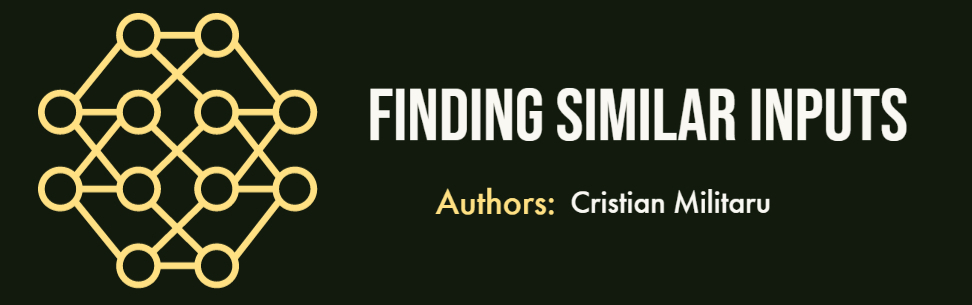

<a href="http://colab.research.google.com/github/mathysgrapotte/deepexplain/blob/main/06_similar_inputs.ipynb"><img data-canonical-src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" src="https://colab.research.google.com/assets/colab-badge.svg"></a>

## Introduction
Neural network classifiers usually make mistakes on test data. 

![Network Misclassificaton](https://drive.google.com/uc?export=view&id=1p5K8QTbYvfcTLvjNIXjna1H3SO1mum5s)

This method may help to explain why an input was misclassified. We will:
- Train a neural network on MNIST
- Find a few misclassified test inputs
- Answer the question: which are the training examples most similar to the misclassifed input from the point of view of the network?

Our goal is to obtain similar inputs:

![Similar inputs example](https://drive.google.com/uc?export=view&id=1FegdgNS8yhqvGkPUOlQRHzEkXlWAs8gc)

## Method
This method is inspired from [Caruana et al (1999)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2232607/).

We will save the activations of one hidden layer for the whole training dataset.

![Method diagram](https://drive.google.com/uc?export=view&id=1BcnEpgFmQTKC3u7HNyZXe91V3-evflzE)

The activations will look like this:

|                  | Neuron 1 | Neuron 2 | Neuron 3 |   ...    | Neuron n |
| ---------------- | -------- | -------- | -------- | -------- | -------- |
| Training image 1 |    0.5   |   0.7    |   2.1    |   ...    |   -1.1   |
| Training image 2 |    -1.5  |   1.8    |   -3.2   |   ...    |   2.7    |
| Training image 3 |    0.2   |   -0.3   |   1.1    |   ...    |   3.5    |
|       ...        |    ...   |   ...    |   ...    |   ...    |   ...    |
| Training image N |   -1.2   |   1.5    |   0.1    |   ...    |   0.7    |
| Test image       |   0.8    |   0.3    |   0.9    |   ...    |   0.2    |

Then, we will compare the activations of the **test image** with **each** training image, and find the closest ones.

To find the closest training image we can use a **K-Nearest-Negihbor** approach with Euclidean distance.

In 2-dimensions, the Euclidean distance between two points is

$d = \sqrt{(x_1 - x_0)^2 + (y_1 - y_0)^2}$

In n dimensions we can do the same

$d = \sqrt{(x_1 - x_0)^2 + (y_1 - y_0)^2 + (z_1 - z_0)^2 + ...}$

For example, in the table above, the distance between *Test image* and *Training image 1* would be computed as:

$d = \sqrt{(0.8 - 0.5)^2 + (0.3 - 0.7)^2 + (0.9 - 2.1)^2 + ... + (0.2 - (-1.1))^2)}$

We compute the distance between *Test image* and each training image, then choose the images with smallest distance.

> ⚠️ This method relies on unverified assumptions: 
> 1. two inputs are similar from the network's point of view if they have similar activations; 
> 2. comparing activations with euclidean distance is a good idea.
> 
> The method can be used to get a hypothesis, but it will require further verification.

> Note: in the original paper, they record *all* layers. We picked only one for simplicity.

## Code

In [2]:
#@title Download dataset and train the model
%pip install torch torchvision
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
mnist_train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
mnist_test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())
mnist_train_loader = torch.utils.data.DataLoader(mnist_train_dataset,batch_size=64, shuffle=True)
mnist_test_loader = torch.utils.data.DataLoader(mnist_test_dataset,batch_size=1000, shuffle=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#@title Training the model

class mnist_conv_model(nn.Module):
    def __init__(self, loss=nn.CrossEntropyLoss()):
        super(mnist_conv_model, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, kernel_size=5)
        self.conv2 = nn.Conv2d(5, 2, kernel_size=5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(800, 50)
        self.fc2 = nn.Linear(50, 10)
        self.softmax = nn.Softmax(dim=1)
        self.loss=loss

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = self.flatten(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return self.softmax(x)

def trainstep(model,optimizer,batch):
    labels=batch[1]

    optimizer.zero_grad()
    
    probs=model(batch[0])
    loss=model.loss(probs,labels)

    loss.backward()
    optimizer.step()

    return loss.detach()

def accuracy(model,batch):
    n=batch[0].shape[0]
    
    labels=batch[1]
    probabilities=model(batch[0])
    predictions=probabilities.max(dim=1)[1]
    
    correct=0

    for i in range(n):
        if predictions[i]==labels[i]:
            correct+=1
    return correct/n
    

model=mnist_conv_model()
optimizer=torch.optim.Adam(model.parameters(),lr=1e-4)

for i in range(3): # for such a simple problem, 3 epochs shall do
    full_loss=0
    full_accuracy=0
    for j,batch in enumerate(mnist_train_loader):
        loss=trainstep(model,optimizer,batch)
        full_loss=full_loss*j/(j+1)+loss.detach()/(j+1) # compute average in a 'sliding' manner, maybe familiar from RL
        full_accuracy=full_accuracy*j/(j+1)+accuracy(model,batch)/(j+1)
    print('epoch %d completed'%(i+1))
    print('loss: %f' % (full_loss))
    print('accuracy: %f'%(full_accuracy))
    
val_batch=next(iter(mnist_test_loader))
print('accuracy on test data: %f'%(accuracy(model,val_batch)))

epoch 1 completed
loss: 1.812540
accuracy: 0.702858
epoch 2 completed
loss: 1.574334
accuracy: 0.898854
epoch 3 completed
loss: 1.558219
accuracy: 0.910015
accuracy on test data: 0.924000


In [ ]:
# By default, when given inputs, the model returns only the outputs.
# To record activations in PyTorch, we can use a forward hook, which is a regular Python function. 
# When we attach the hook to a layer, our hook will be called every time that layer is used.
activations = None # This global variable is used to read the activations after the computations
def hook_fc1(model, input, output):
  global activations
  activations = output.detach() # Only record the layer's output

# Attach the hook to model.fc1 layer
model.fc1.register_forward_hook(hook_fc1);

In [ ]:
# Record the activations of all training examples
# To avoid the complexity of batching, we load the full training dataset in 1 batch
full_training_dataset_loader = torch.utils.data.DataLoader(mnist_train_dataset, batch_size=len(mnist_train_dataset))
with torch.no_grad(): # disable gradients to make computations faster
  activations = None
  train_images, train_labels = next(iter(full_training_dataset_loader))
  # Predict for all training images
  train_outputs = model(train_images).data
  # train_outputs contains a list of probabilities (one for each digit 0-9)
  # For misclassifications, we're interested in the digit having the highest probability
  train_predictions = train_outputs.max(dim=1)[1]
  # Save the activations in a separate variable
  train_activations = activations

  print(train_images.shape, train_labels.shape, train_predictions.shape, train_activations.shape)

torch.Size([60000, 1, 28, 28]) torch.Size([60000]) torch.Size([60000]) torch.Size([60000, 50])


In [ ]:
# Record the activations of all test examples
full_test_dataset_loader = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=len(mnist_test_dataset))
with torch.no_grad():
  activations = None
  test_images, test_labels = next(iter(full_test_dataset_loader))
  test_outputs = model(test_images).data
  test_predictions = test_outputs.max(dim=1)[1]
  test_activations = activations
  print(test_images.shape, test_labels.shape, test_predictions.shape, test_activations.shape)

torch.Size([10000, 1, 28, 28]) torch.Size([10000]) torch.Size([10000]) torch.Size([10000, 50])


In [ ]:
# Find the first 4 images that were misclassified
misclassification_indices = (test_predictions - test_labels).nonzero(as_tuple=True)[0].tolist()
test_indices = misclassification_indices[0:4]

### Finding the closest examples:


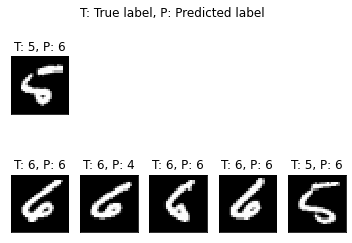

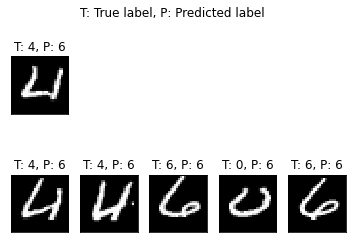

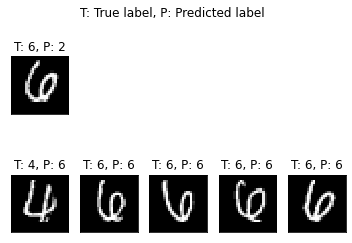

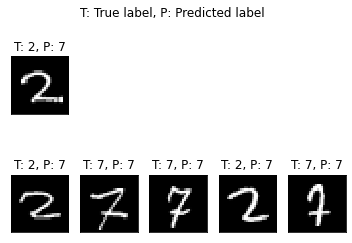

In [ ]:
# For the first 4 misclassifications:
for test_idx in test_indices:
  # Find the closest examples
  number_of_examples = 5
  differences = train_activations - test_activations[test_idx:test_idx+1] # Take all train activations and subtract the test image's activation
  distances = torch.norm(differences, dim=1, p=None) # Do the squared sum of all values 
  knn = distances.topk(number_of_examples, largest=False).indices # Get the indices of the smallest distances
  # print('Smallest distances indices: ', knn.tolist())
  # print('Smallest distances: ', distances.index_select(0, knn).tolist())

  # Draw the test image and the most similar training images
  fig = plt.figure()
  fig.suptitle("T: True label, P: Predicted label");
  plt.tight_layout()
  plt.subplot(2,number_of_examples,1)
  plt.imshow(test_images[test_idx][0], cmap='gray', interpolation='none')
  plt.title("T: {}, P: {}".format(test_labels[test_idx], test_predictions[test_idx]))
  plt.xticks([])
  plt.yticks([])
  for i in range(number_of_examples):
    plt.subplot(2,number_of_examples,i+1+number_of_examples)
    plt.imshow(train_images[knn[i]][0], cmap='gray', interpolation='none')
    plt.title("T: {}, P: {}".format(int(train_labels[knn[i]].item()), int(train_predictions[knn[i]].item())))
    plt.xticks([])
    plt.yticks([])

From the above examples, it is unclear why the misclassifications occur. Most of the times, the method returns similar images from the same true label that are also misclassified. To get more relevant results, we can only show training images with the true label equal to predicted value of test image.

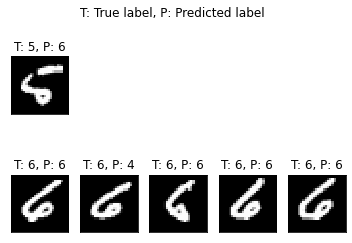

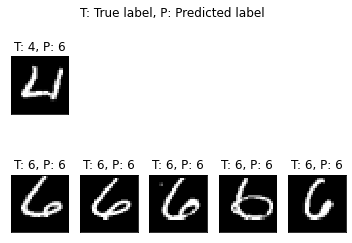

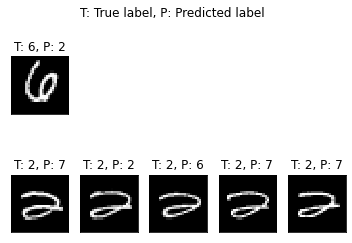

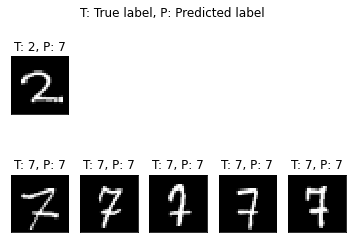

In [ ]:
# We can repeat the same procedure, but pick only training images from the test image's predicted label
# (if test image is a 9 but misclassified as a 4, show closest training images from class 4)
for test_idx in test_indices:
  number_of_examples = 5
  train_indices = (train_labels == test_predictions[test_idx]).nonzero(as_tuple=True)[0]

  filtered_train_images = train_images.index_select(0, train_indices)
  filtered_train_labels = train_labels.index_select(0, train_indices)
  filtered_train_activations = train_activations.index_select(0, train_indices)
  filtered_train_predictions = train_predictions.index_select(0, train_indices)

  distances = torch.norm(filtered_train_activations - test_activations[test_idx:test_idx+1], dim=1, p=None)
  knn = distances.topk(number_of_examples, largest=False).indices
  # print('Smallest distances indices: ', knn.tolist())
  # print('Smallest distances: ', distances.index_select(0, knn).tolist())

  fig = plt.figure()
  fig.suptitle("T: True label, P: Predicted label");
  plt.tight_layout()
  plt.subplot(2,number_of_examples,1)
  plt.imshow(test_images[test_idx][0], cmap='gray', interpolation='none')
  plt.title("T: {}, P: {}".format(test_labels[test_idx], test_predictions[test_idx]))
  plt.xticks([])
  plt.yticks([])
  for i in range(number_of_examples):
    plt.subplot(2,number_of_examples,i+1+number_of_examples)
    plt.imshow(filtered_train_images[knn[i]][0], cmap='gray', interpolation='none')
    plt.title("T: {}, P: {}".format(int(filtered_train_labels[knn[i]].item()), int(filtered_train_predictions[knn[i]].item())))
    plt.xticks([])
    plt.yticks([])

### Interpretation

In the example below:

<img src="https://drive.google.com/uc?export=view&id=1z2xlrt8sczKkpExevy2tZ0Pw5ntbiG08" alt="Five misclassified as six" width="400"/>

we can see the similarities between the test image of a digit "5" and some training images of the digit "6": they all have a small circle on the bottom, and a vertical line. Two distinctions would be that:
- for the 5 the circle's left part is not aligned with the vertical line, and 
- there is a space between the top dash of 5 and the rest (which may imply the pen was raised from the paper).

To fix this misclassification, one can try to change network's parameters or augment the dataset with small variations (rotations, translations, small noise) of the problematic image.

## Conclusion
This method reveals similarities between test image with wrong label and training images with that label. This can help in 2 ways:
1. Debugging: in some cases the machine learning developer can fix the problems by using data augmentation for images that occur infrequently and have insufficient training data, or adjusting the model parameters. In other cases it might be difficult even for a human to distinguish between 2 digits (example: some 7s and 1s are almost identical), and it might be acceptable for the network to make that mistake.
2. Expert verification: in domains such as medicine or justice it is useful to find similar cases such that an expert can check the output. Similar inputs are a readable explaination even for non-technical users, it is similar to the way we humans think: by making connections between similar entities.

## Further exercises
If you want to practice more about this method, you can try to:
1. Record layer *fc2* instead of *fc1* and see if the results change
2. Instead of Euclidian distance, when computing difference between 2 inputs, use a different distance metric, and check if the results are similar. For example, use L1 norm $d = |x_1 - x_0| + |y_1 - y_0| + |z_1 - z_0| + ...$.